## ***Imports***

In [99]:
import sklearn
import pandas as pd
from sklearn import preprocessing
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from itertools import combinations
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.multiclass import OneVsOneClassifier
from itertools import cycle

from scipy import stats as st
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import math
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve, auc
sns.set()
warnings.filterwarnings("ignore")

##***Utility functions***

In [58]:
def preprocess(data):
  le1 = preprocessing.LabelEncoder()
  le1.fit(data["Island"])

  le2=preprocessing.LabelEncoder()
  le2.fit(data["Clutch Completion"])

  le3=preprocessing.LabelEncoder()
  le3.fit(data["Sex"])

  le4=preprocessing.LabelEncoder()
  le4.fit(data["Species"])

  return (le1,le2,le3,le4)


def test_nan(df):
  null_vals=[]
  nulls=df.isnull()
  for i in range(len(nulls)):
    for j in range(len(nulls.iloc[i,:])):
      if(nulls.iloc[i,j]):
        null_vals.append((i,j))
  return null_vals


def replace_nan(data,null_vals,discrete):
  for i in null_vals:
    if(i[1] in discrete):
      mode=data[data.columns[i[1]]].mode()[0]
      data.iloc[i[0],i[1]]=mode
    else:
      mean=data[data.columns[i[1]]].mean()
      data.iloc[i[0],i[1]]=mean
  return data


def accuracy(pred,actual):
  accu=0
  for i in range(len(pred)):
    accu+=(pred[i]==actual[i])
  # print(accu/len(ytest))
  return accu/len(ytest)

def normalize_attributes(columns,df):
  scalers=[]
  scaler = MinMaxScaler()
  scaler.fit(df.iloc[:,columns])
  vals=scaler.transform(df.iloc[:,columns])
  df.iloc[:,columns]=vals
  return (scaler,vals)

def voting(predictions):
  predictions=np.array(predictions)
  predictions=predictions.transpose()
  preds=[]
  for i in predictions:
    preds.append(st.mode(i)[0][0])
  return preds

def preprocess_test_data(df,le1,le2,le3,le4):
  df["Island"]=le1.transform(df["Island"])
  df["Clutch Completion"]=le2.transform(df["Clutch Completion"])
  df["Sex"]=le3.transform(df["Sex"])
  return df

def feature_engineering(testdf,le1,le2,le3,le4,scaler1,scaler2,pca,scaled):  
  testdf=preprocess_test_data(testdf,le1,le2,le3,le4)
  testdf.iloc[:,scaled]=scaler1.transform(testdf.iloc[:,scaled])
  xtest=testdf.iloc[:,:].values
  pcom=pca.transform(testdf.iloc[:,:])
  principalDf = pd.DataFrame(data = pcom,  columns = ['principal component {}'.format(i+1) for i in range(n_components)])
  testdf=principalDf
  testdf.iloc[:,:]=scaler2.transform(testdf.iloc[:,:])
  xtest=testdf.iloc[:,:].values
  return testdf

## **Pre processing**

In [59]:
df=pd.read_csv("penguins_train.csv")
cols=list(df.columns)
discrete=[cols.index("Island"),cols.index("Clutch Completion"),cols.index("Sex"),cols.index("Species")]
null_vals=test_nan(df)
df=replace_nan(df,null_vals,discrete)
null_vals=test_nan(df)
for i in range(len(df)):
  if(df.iloc[i,cols.index("Sex")]=="."):
    df.drop([i],inplace=True)
    break
le1,le2,le3,le4=preprocess(df)


## ***All vs All***

In [137]:
df = df.sample(frac=1).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values,df.iloc[:,-1:].values,test_size=0.3,random_state=1)
train=pd.DataFrame(X_train,columns=cols[:-1])
train["Island"]=le1.transform(train["Island"])
train["Clutch Completion"]=le2.transform(train["Clutch Completion"])
train["Sex"]=le3.transform(train["Sex"])
train[cols[-1]]=y_train
train["Species"]=le4.transform(train["Species"])
xtrain=train.iloc[:,:-1].values
ytrain=train.iloc[:,-1].values
print(train["Species"].value_counts())
print(le4.inverse_transform([0,2,1]))
oversample = SMOTE()
x, y = oversample.fit_resample(xtrain, ytrain)
train=pd.DataFrame(x,columns=cols[:-1])
train[cols[-1]]=y

scaled=[cols.index("Culmen Length (mm)"),cols.index("Culmen Depth (mm)"),cols.index("Flipper Length (mm)"),cols.index("Body Mass (g)"),cols.index("Delta 15 N (o/oo)"),cols.index("Delta 13 C (o/oo)")]
scaler1,vals=normalize_attributes(scaled,train)
train.iloc[:,scaled]=vals
xtrain=train.iloc[:,:-1].values
ytrain=train.iloc[:,-1].values

n_components=5
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(xtrain)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component {}'.format(i+1) for i in range(n_components)])
principalDf[cols[-1]]=train.iloc[:,-1:]
train=principalDf

scaler2,vals=normalize_attributes(range(len(train.columns))[:-1],train)
train.iloc[:,:-1]=vals
xtrain=train.iloc[:,:-1].values
ytrain=train.iloc[:,-1].values

0    81
2    74
1    36
Name: Species, dtype: int64
['Adelie Penguin (Pygoscelis adeliae)' 'Gentoo penguin (Pygoscelis papua)'
 'Chinstrap penguin (Pygoscelis antarctica)']


In [138]:
classes=le4.classes_
labels=le4.transform(classes)
allpairs=list(combinations(labels,2))

def all_vs_all(train,classifier,xtest):
  allpred=[]
  for i in range(len(allpairs)):
    newdf=train[(train.Species==allpairs[i][0]) | (train.Species==allpairs[i][1])]
    x=newdf.iloc[:,:-1].values
    y=newdf.iloc[:,-1:].values

    model=svm.SVC(kernel="rbf").fit(x, y)

    if(classifier=="SVM"):
      model=svm.SVC(kernel="rbf").fit(x, y)
    if(classifier=="LogisticRegression"):
      model = LogisticRegression(random_state=0).fit(x, y)
    if(classifier=="RandomForest"):
      model=RandomForestClassifier(max_depth=4, random_state=0)
    if(classifier=="DecisionTree"):
      model=tree.DecisionTreeClassifier()
    if(classifier=="KNN"):
      model=KNeighborsClassifier(n_neighbors=3)

    model.fit(x,y)
    pred=model.predict(xtest)
    allpred.append(pred)
  return allpred

## ***Accuracies on testing data for different models***

In [139]:
test=pd.DataFrame(X_test,columns=cols[:-1])
test.to_csv("sample_test.csv")
test=feature_engineering(test,le1,le2,le3,le4,scaler1,scaler2,pca,scaled)
xtest=test.values
ytest=le4.transform(y_test)
diffmodels=["DecisionTree","SVM","RandomForest","LogisticRegression","KNN"]
for i in diffmodels:
  allpred=all_vs_all(train,i,xtest)
  allpred=all_vs_all(train,i,xtest)
  allpred=all_vs_all(train,i,xtest)
  allpred=all_vs_all(train,i,xtest)
  allpred=all_vs_all(train,i,xtest)
  preds=voting(allpred)
  print(i,"Accuracy : ",accuracy(preds,ytest))

DecisionTree Accuracy :  0.9512195121951219
SVM Accuracy :  0.975609756097561
RandomForest Accuracy :  0.975609756097561
LogisticRegression Accuracy :  0.9634146341463414
KNN Accuracy :  0.9512195121951219


### ***Visualizations***

In [140]:
bestmodel="SVM"
allpred=[]
allprobs=[[0 for i in range(len(le4.classes_))] for j in range(len(xtest))]
for i in range(len(allpairs)):
  newdf=train[(train.Species==allpairs[i][0]) | (train.Species==allpairs[i][1])]
  x=newdf.iloc[:,:-1].values
  y=newdf.iloc[:,-1:].values
  model=svm.SVC(kernel="rbf",probability=True).fit(x, y)
  model.fit(x,y)
  probs=model.predict_proba(xtest)
  pred=model.predict(xtest)
  allpred.append(pred)
  for j in range(len(probs)):
    allprobs[j][allpairs[i][0]]+=probs[j][0]
    allprobs[j][allpairs[i][1]]+=probs[j][1]

preds=voting(allpred)
print("SVM","Accuracy : ",accuracy(preds,ytest))
  

SVM Accuracy :  0.975609756097561


In [141]:
ypred=le4.inverse_transform(preds)
yact=le4.inverse_transform(ytest)
cnf_matrix=confusion_matrix(ypred, yact,labels=le4.classes_)

In [142]:
cnf=pd.DataFrame(cnf_matrix,columns=le4.classes_,index=le4.classes_)

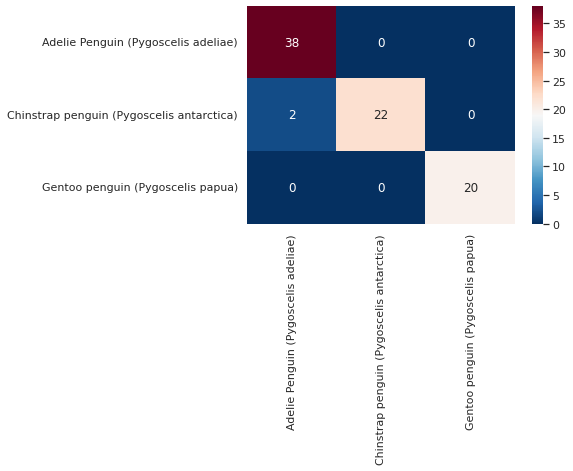

In [143]:
sns.heatmap(cnf, annot=True,cmap="RdBu_r")

In [144]:
for i in range(len(allprobs)):
  allprobs[i]=list(map(lambda x: x/(len(le4.classes_)),allprobs[i]))

In [ ]:
allprobs=np.array(allprobs)
allprobs

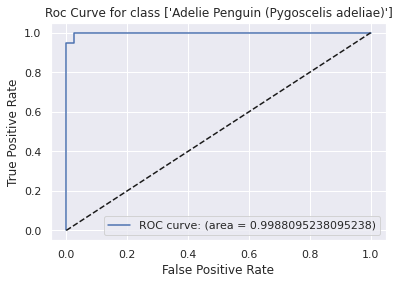

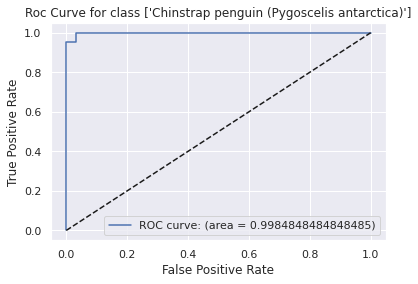

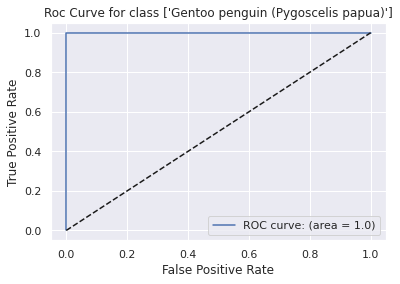

In [147]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_label = label_binarize(ytest, classes=range(len(le4.classes_)))
for i in range(len(le4.classes_)):
  plt.title("Roc Curve for class {}".format(le4.inverse_transform([i])))
  fpr[i], tpr[i], _ = roc_curve(y_label[:, i], allprobs[:, i])
  # print(fpr[i],tpr[i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  plt.plot(fpr[i],tpr[i],label="ROC curve: (area = {})".format(roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  print()

In [148]:
clf = OneVsOneClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0)).fit(train.iloc[:,:-1], train.iloc[:,-1:])
predictions=clf.predict(xtest)
report=pd.DataFrame(classification_report(predictions,ytest,output_dict=True)).T
report=report.style.background_gradient(cmap="RdBu_r",
                             subset=pd.IndexSlice['0':'9', :'f1-score'])

report

,precision,recall,f1-score,support
0,0.950000,1.000000,0.974359,38.000000
1,1.000000,0.916667,0.956522,24.000000
2,1.000000,1.000000,1.000000,20.000000
accuracy,0.975610,0.975610,0.975610,0.975610
macro avg,0.983333,0.972222,0.976960,82.000000
weighted avg,0.976829,0.975610,0.975392,82.000000


## **Rough work (no need to run)**

In [14]:
df=pd.read_csv("penguins_train.csv")
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1].values,df.iloc[:,-1:].values,test_size=0.3,random_state=1)
sampletrain=pd.DataFrame(X_train,columns=cols[:-1])
sampletrain[cols[-1]]=y_train
sampletrain.set_index(cols[0],inplace=True)
sampletrain.to_csv("sample_train.csv")

sampletest=pd.DataFrame(X_test,columns=cols[:-1])
sampletest.set_index(cols[0],inplace=True)
sampletest.to_csv("sample_test.csv")

In [ ]:
results=y_test
sampleres=pd.DataFrame(y_test,columns=cols[-1:])
sampleres.to_csv("sample_result.csv")


In [ ]:
# ## Source sklearn
# def plot_roc_curve(y_test, y_pred):
#      n_classes = len(np.unique(y_test))
#      print(n_classes)
#      y_test = label_binarize(y_test, classes=np.arange(3))

#      # Compute ROC curve and ROC area for each class
#      fpr = dict()
#      tpr = dict()
#      roc_auc = dict()
#      thresholds = dict()
#      for i in range(n_classes):
#        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
#      roc_auc[i] = auc(fpr[i], tpr[i])

#      # Compute micro-average ROC curve and ROC area
#      fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
#      roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#      # First aggregate all false positive rates
#      all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#      # Then interpolate all ROC curves at this points
#      mean_tpr = np.zeros_like(all_fpr)
#      for i in range(n_classes):
#        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#      # Finally average it and compute AUC
#      mean_tpr /= n_classes

#      fpr["macro"] = all_fpr
#      tpr["macro"] = mean_tpr
#      roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#      # Plot all ROC curves
#      #plt.figure(figsize=(10,5))
#     #  plt.figure(dpi=600)
#      lw = 2
#      plt.plot(fpr["micro"], tpr["micro"],
#      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
#      color="deeppink", linestyle=":", linewidth=4,)

#      plt.plot(fpr["macro"], tpr["macro"],
#      label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
#      color="navy", linestyle=":", linewidth=4,)

#      colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
#      for i, color in zip(range(n_classes), colors):
#        plt.plot(fpr[i], tpr[i], color=color, lw=lw,)
#       #  label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

#      plt.plot([0, 1], [0, 1], "k--", lw=lw)
#      plt.xlim([0.0, 1.0])
#      plt.ylim([0.0, 1.05])
#      plt.xlabel("False Positive Rate")
#      plt.ylabel("True Positive Rate")
#      plt.title("Receiver Operating Characteristic (ROC) curve")
#      plt.legend()
#plot_roc_curve(ytest,clf.decision_function(xtest))